In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder as OE
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

In [7]:
d = "C:\kaggle_data\credit_card"

In [8]:
lst = os.listdir(d)
print(lst)

['sample_submission.csv', 'test.csv', 'train.csv']


In [9]:
train = pd.read_csv(d + '\\' +lst[2])
test = pd.read_csv(d + '\\' +lst[1])
ss = pd.read_csv(d + '\\' +lst[0])

In [10]:
total = pd.concat([train, test])

In [11]:
drop_lst = ['gender','car','reality','FLAG_MOBIL','work_phone','phone','email']

In [12]:
drop_lst.remove('gender')

# 개요
## target 변수
- credit: 타겟변수, 
    [0, 1, 2]

## 설명 변수
- gender: 성별 [M, F]
- car : 차량 소유 여부 [Y, N]
- reality: 부동산 소유 여부 [Y, N]
- FLAG_MOBIL: 핸드폰 소유 여부, T/F, [1]
- work_phone: 업무용 전화 소유 여부, T/F, [0,1]
- phone : 전화 소유 여부, T/F, [0,1]
- email : 이메일 소유 여부, T/F, [0,1]  

In [25]:
def make_plot(col,l1,l2):
    # 있는 비율
    yes = train.loc[(train[col]==l1),'credit'].value_counts().values
    y_lst = []
    for i in yes:
        y_lst.append(i/sum(yes))
        print(i/sum(yes)*100)

    print()
    # 없는 비율
    no = train.loc[(train[col]==l2),'credit'].value_counts().values
    n_lst = []
    for n in no:
        n_lst.append(n/sum(no))
        print(n/sum(no)*100)

    df = pd.DataFrame([y_lst,n_lst])
    
    return df.plot.bar(stacked=True, figsize=(10,7),title=col,legend=True)

# 이진변수들

- gender: 성별 [M, F]
- car : 차량 소유 여부 [Y, N]
- reality: 부동산 소유 여부 [Y, N]
- FLAG_MOBIL: 핸드폰 소유 여부, T/F, [1]
- work_phone: 업무용 전화 소유 여부, T/F, [0,1]
- phone : 전화 소유 여부, T/F, [0,1]
- email : 이메일 소유 여부, T/F, [0,1]

## 1. gender
- M: Male
- F: Female

<AxesSubplot:xlabel='gender', ylabel='count'>

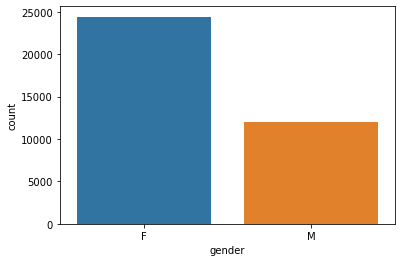

In [9]:
sns.countplot(total['gender'])

Text(0.5, 1.0, 'test_gender')

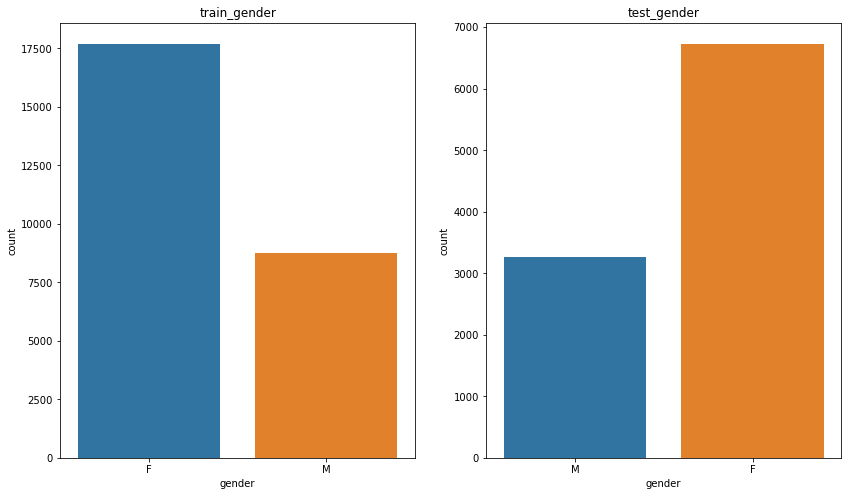

In [10]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,8))
sns.countplot(data=train, x='gender', ax=ax[0])
ax[0].set_title('train_gender')
sns.countplot(data=test, x='gender', ax=ax[1])
ax[1].set_title('test_gender')

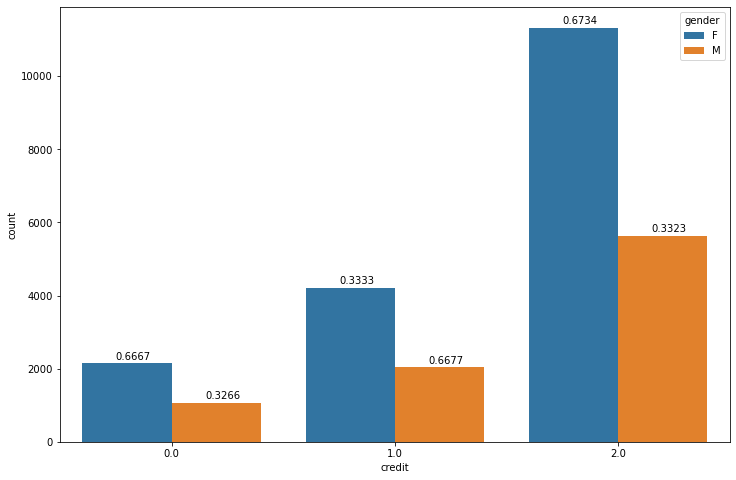

In [11]:
# 각 신용등급에서의 성비
# 중간에 잘못 들어간 값이 있긴 하지만 어쨌든 여성이 2/3, 남성이 1/3
fig, ax = plt.subplots(figsize=(12,8))

sns.countplot(x='credit',data=train,hue='gender',ax=ax)
gender = ['F','M']
lst = []
for c in sorted(train['credit'].unique()):
    for g in gender:
        temp = train.loc[train['credit']==c]
        total = len(temp)
        temp = temp.loc[train['gender']==g]
        gende = len(temp)
        lst.append(gende/total)
for v, p in zip(lst, ax.patches):
    ax.annotate(round(v,4), (p.get_x()+0.15, p.get_height()+100))

64.01649997174663
23.845849579024694
12.137650449228683

64.37214611872146
23.367579908675797
12.26027397260274


<AxesSubplot:title={'center':'gender'}>

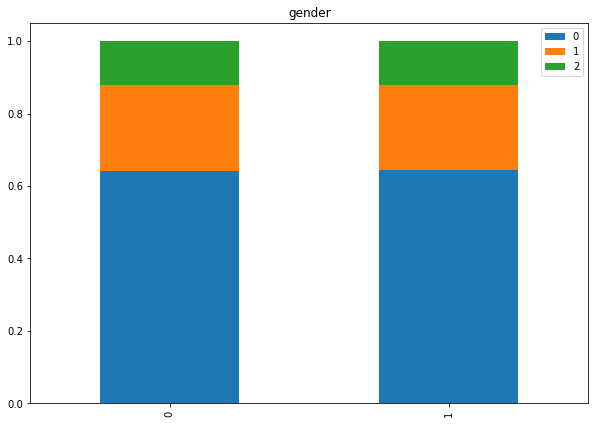

In [35]:
make_plot('gender','F','M')

## gender
- train: 남성 수 > 여성 수
- test : 여성 수 > 남성 수

- baseline에서 gender drop했더니 조금 더 좋아짐(0.001점) -> 유의미한 변수인지 확신 불가

## 2. car

<AxesSubplot:xlabel='car', ylabel='count'>

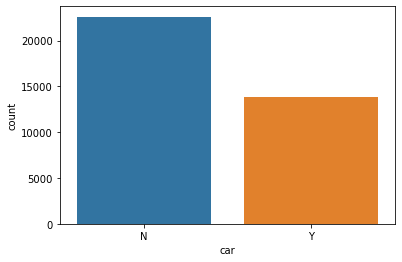

In [29]:
sns.countplot(total['car'])

Text(0.5, 1.0, 'test_car')

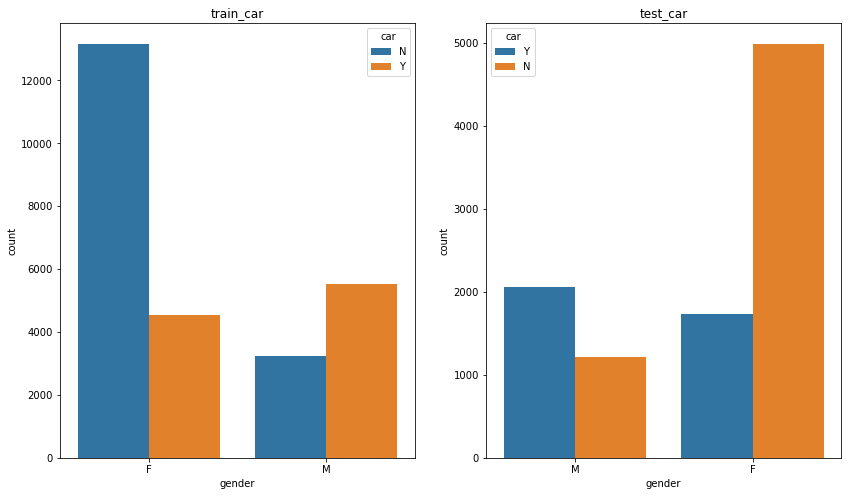

In [32]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,8))
sns.countplot(data=train, x='gender', ax=ax[0],hue='car')
ax[0].set_title('train_car')
sns.countplot(data=test, x='gender', ax=ax[1],hue='car')
ax[1].set_title('test_car')

Text(0.5, 1.0, 'credit by car')

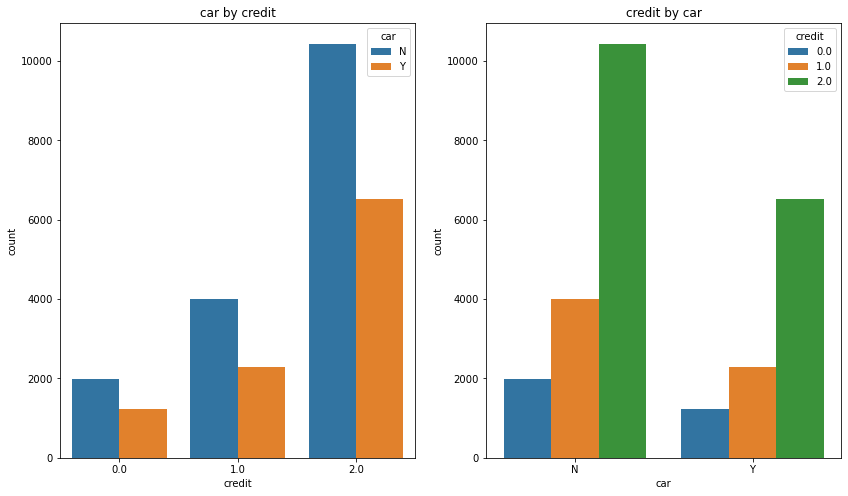

In [36]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,8))

sns.countplot(data=train, x='credit', ax=ax[0], hue='car')
ax[0].set_title('car by credit')

sns.countplot(data=train, x='car', ax=ax[1], hue='credit')
ax[1].set_title('credit by car')

In [44]:
# car의 유무에 따른 각 credit 등급의 비율 변화
# 차가 있는 비율
yes = train.loc[(train['car']=='Y'),'credit'].value_counts().values
for i in yes:
    print(i/sum(yes)*100)

print()
# 차가 없는 비율
no = train.loc[(train['car']=='N'),'credit'].value_counts().values
for n in no:
    print(n/sum(no)*100)

64.99452572907336
22.663481636309346
12.341992634617299

63.60755636806825
24.314442413162705
12.078001218769044


64.99452572907336
22.663481636309346
12.341992634617299

63.60755636806825
24.314442413162705
12.078001218769044


<AxesSubplot:title={'center':'car'}>

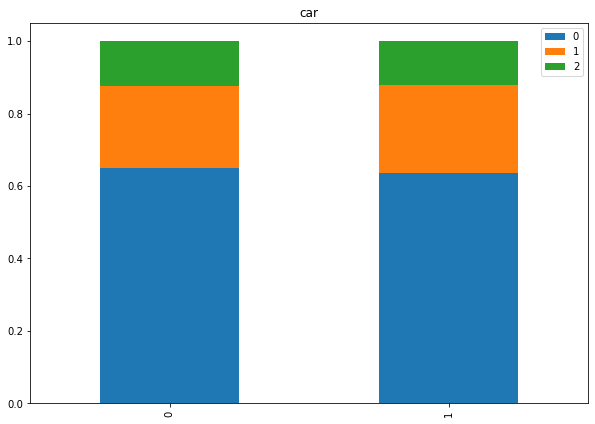

In [36]:
make_plot('car','Y','N')

### car
#### train
- 여성은 차량이 없는 사람이  더 많다
- 남성은 차량 가지고 있는 사람이 더 많다.

#### 

## 3. reality: 부동산 소유 여부 [Y, N]

<AxesSubplot:xlabel='reality', ylabel='count'>

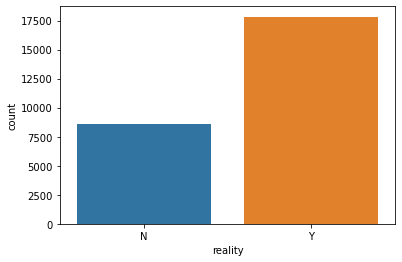

In [37]:
sns.countplot(train['reality'])

<AxesSubplot:xlabel='reality', ylabel='count'>

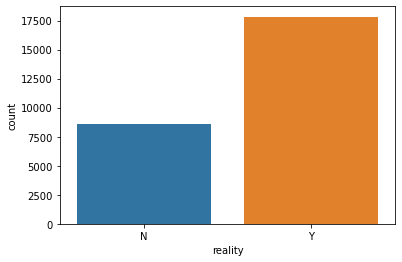

In [38]:
sns.countplot(train['reality'])

63.60067302299495
24.296130117779025
12.103196859226022

65.2370464819752
22.429581546308103
12.333371971716703


<AxesSubplot:title={'center':'reality'}>

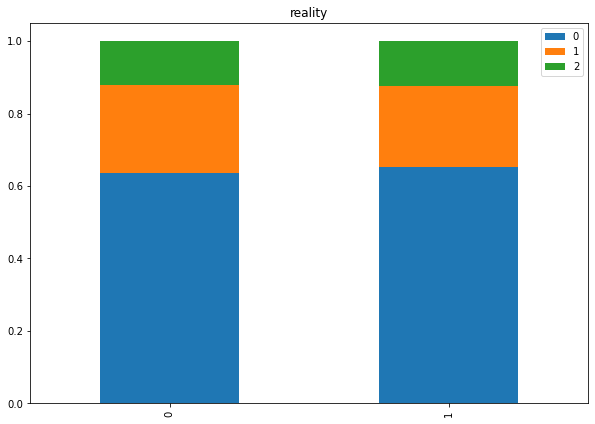

In [39]:
make_plot('reality','Y','N')

## 4. FLAG_MOBIL: 핸드폰 소유 여부, T/F, [1]

<AxesSubplot:xlabel='FLAG_MOBIL', ylabel='count'>

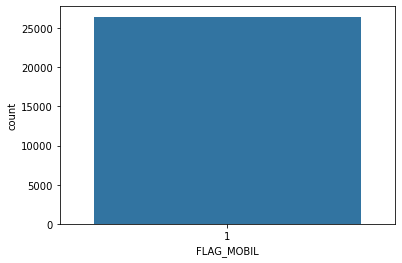

In [40]:
sns.countplot(train['FLAG_MOBIL'])

<AxesSubplot:xlabel='FLAG_MOBIL', ylabel='count'>

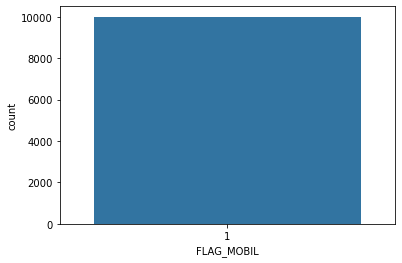

In [41]:
sns.countplot(test['FLAG_MOBIL'])

## 5. work_phone: 업무용 전화 소유 여부, T/F, [0,1]

<AxesSubplot:xlabel='work_phone', ylabel='count'>

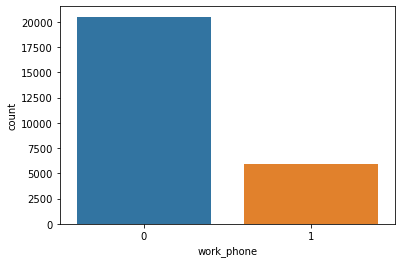

In [42]:
sns.countplot(train['work_phone'])

<AxesSubplot:xlabel='work_phone', ylabel='count'>

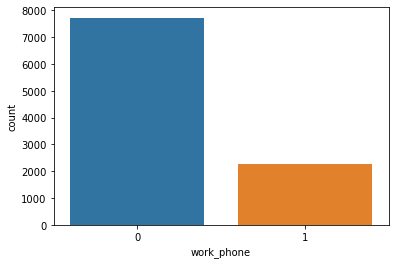

In [43]:
sns.countplot(test['work_phone'])

63.60067302299495
24.296130117779025
12.103196859226022

65.2370464819752
22.429581546308103
12.333371971716703


<AxesSubplot:title={'center':'reality'}>

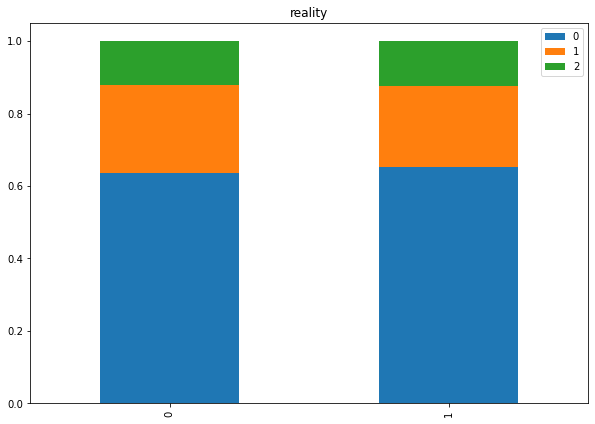

In [44]:
make_plot('reality','Y','N')

## 6. phone : 전화 소유 여부, T/F, [0,1]

<AxesSubplot:xlabel='phone', ylabel='count'>

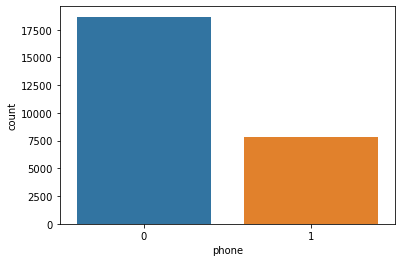

In [45]:
sns.countplot(train['phone'])

<AxesSubplot:xlabel='phone', ylabel='count'>

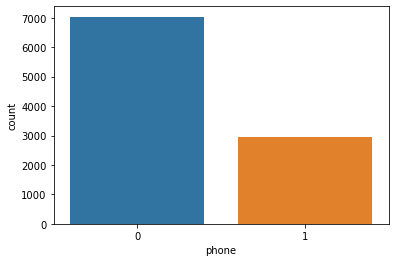

In [46]:
sns.countplot(test['phone'])

63.82283633247644
24.15381319622965
12.023350471293917

64.88118175979449
22.569043031470777
12.549775208734745


<AxesSubplot:title={'center':'phone'}>

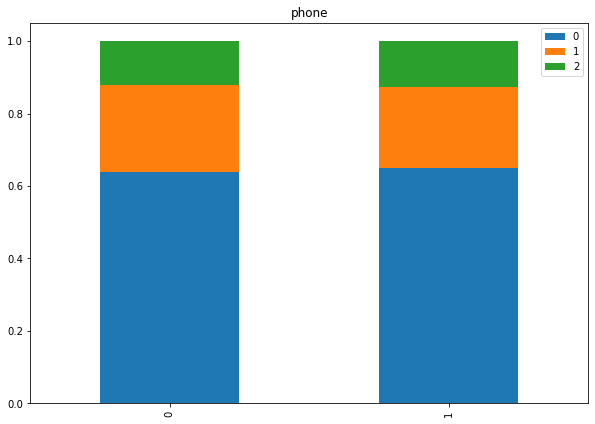

In [47]:
make_plot('phone',0,1)

## 7. email

<AxesSubplot:xlabel='email', ylabel='count'>

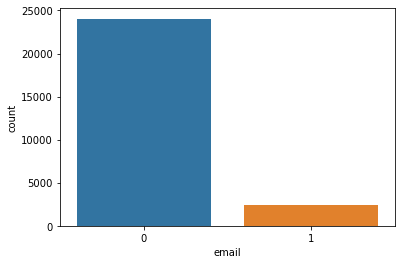

In [48]:
sns.countplot(train['email'])

<AxesSubplot:xlabel='email', ylabel='count'>

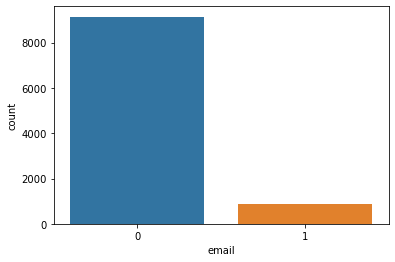

In [50]:
sns.countplot(test['email'])

63.90899259628983
23.8083354130272
12.28267199068297

66.3768115942029
22.48447204968944
11.13871635610766


<AxesSubplot:title={'center':'email'}>

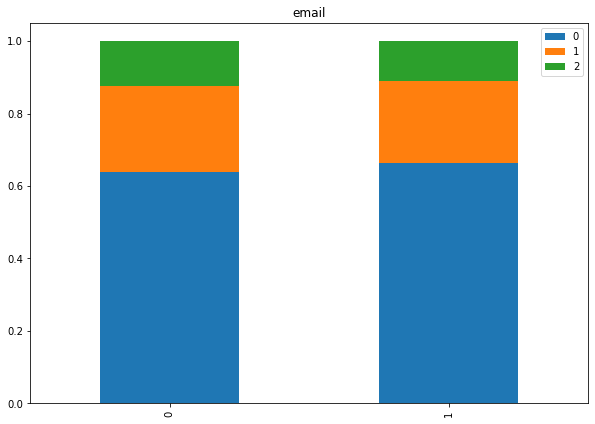

In [51]:
make_plot('email',0,1)

In [29]:
train = train.drop(drop_lst,1)
test = test.drop(drop_lst,1)

# label encoding
- gender, car, reality, work_phone, phone, email, occyp_type, income_type, edu_type, family_size, house_type

In [26]:
from sklearn.preprocessing import OrdinalEncoder as OE
labels = ['occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']

In [27]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [14]:
total.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [15]:
from sklearn.preprocessing import OrdinalEncoder as OE
from sklearn.preprocessing import LabelEncoder as LE
labels = ['gender','occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']
for label in labels:
    enc = LE()
    enc.fit(total[label])
    train[label] = enc.transform(train[label])
    test[label] = enc.transform(test[label])

In [16]:
import xgboost as xgb
rk_clf = xgb.XGBRFClassifier(random_state=1123)
sk_clf = xgb.XGBRFClassifier(random_state=1123)

In [17]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [18]:
cols = ['gender','child_num', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'occyp_type', 'family_size', 'begin_month']

In [19]:
X = train[cols]
y = train['credit']

In [20]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1123)

from sklearn.model_selection import KFold
rkf = KFold(n_splits=5, shuffle=True, random_state=1123)

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
%%time
score_rkf = cross_val_score(rk_clf, X, y, cv=rkf)

Wall time: 5.98 s


In [23]:
%%time
score_skf = cross_val_score(sk_clf, X, y, cv=skf)

Wall time: 5.8 s


In [24]:
score_rkf.mean()

0.6905547191261477

In [25]:
score_skf.mean()

0.6902142044999188

In [26]:
test_X = test[cols]

In [27]:
sk_clf.fit(X, y, eval_metric='logloss')
rk_clf.fit(X,y, eval_metric='logloss')

pred_sk = sk_clf.predict(test_X)
pred_rk = rk_clf.predict(test_X)

In [28]:
ss_sk = pd.concat([ss['index'],pd.get_dummies(pd.Series(pred_sk).astype('int'))],axis=1)
ss_rk = pd.concat([ss['index'],pd.get_dummies(pd.Series(pred_rk).astype('int'))],axis=1)

In [29]:
ss_rk.to_csv('rk_leave_gender.csv',index=False)
ss_sk.to_csv('sk_leave_gender.csv',index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

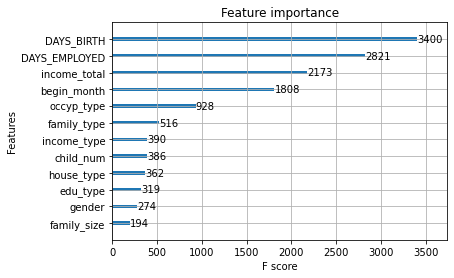

In [30]:
from xgboost import plot_importance
plot_importance(sk_clf)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

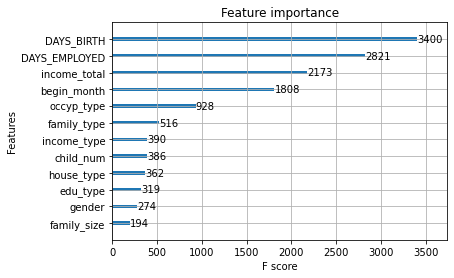

In [31]:
plot_importance(rk_clf)

In [32]:
ss['index']

0       26457
1       26458
2       26459
3       26460
4       26461
        ...  
9995    36452
9996    36453
9997    36454
9998    36455
9999    36456
Name: index, Length: 10000, dtype: int64

In [33]:
import numpy as np
from sympy import Matrix

In [36]:
A = [[1,1,0],[1,-1,0],[1,1,1]]
A = Matrix(A)

In [37]:
A.columnspace()

[Matrix([
 [1],
 [1],
 [1]]),
 Matrix([
 [ 1],
 [-1],
 [ 1]]),
 Matrix([
 [0],
 [0],
 [1]])]

In [38]:
A.nullspace()

[]